In [1]:
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import itertools

import keras
from keras.applications import ResNet50, Xception
from keras.models import Sequential, Model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical 
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

np.random.seed(123)

In [2]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))

def summary_table(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    return summary

def countplot(df, x, x_axis_title,y_axys_title, plot_title):
    plt.figure(figsize=(20,8))
    sns.set(style="ticks", font_scale = 1)
    ax = sns.countplot(data = df,x=x,order = df[x].value_counts().index,palette="Blues_d")
    sns.despine(top=True, right=True, left=True, bottom=False)
    plt.xticks(rotation=0,fontsize = 12)
    ax.set_xlabel(x_axis_title,fontsize = 14,weight = 'bold')
    ax.set_ylabel(y_axys_title,fontsize = 14,weight = 'bold')
    plt.title(plot_title, fontsize = 16,weight = 'bold')  


In [3]:

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

base_skin_dir = os.path.join('..', 'C:/Users/Annu/Desktop/Sem 4/')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*','*', '*.jpg'))}

skin_df = pd.read_csv('C:/Users/Annu/Desktop/Sem 4/HAM10000_metadata.csv')

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


In [4]:
base_skin_dir = os.path.join('..', 'C:/Users/Annu/Desktop/Sem 4')

print(base_skin_dir)


imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}


lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

C:/Users/Annu/Desktop/Sem 4


In [5]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))



skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [6]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [7]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [8]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=123)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_train_mean)/x_train_std

y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1,random_state=123)


x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))


In [9]:

input_shape = (75, 100, 3)
num_classes = 7

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

epochs = 100
batch_size = 20

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=2, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')


dataaugment = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range=90,  
        zoom_range = 0.1,  
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip=True,  
        vertical_flip=True,  
        shear_range = 10) 

dataaugment.fit(x_train)

def history(model):
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                        epochs = epochs, validation_data = (x_validate,y_validate),
                        verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor])

    loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
    predictions = model.predict(x_test)
    loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=2)
    loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=2)
    return (predictions,accuracy_t,accuracy_v,accuracy)


In [10]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

y_pred, accuracy_t,accuracy_v,accuracy = history(model)
print("Training: accuracy = %f" % (accuracy_t))
print("Validation: accuracy = %f" % (accuracy_v))
print("Test: accuracy = %f" % (accuracy))

Epoch 1/100
360/360 - 428s - loss: 1.3131 - accuracy: 0.5800 - val_loss: 0.8875 - val_accuracy: 0.6933
Epoch 2/100
360/360 - 423s - loss: 0.9329 - accuracy: 0.6690 - val_loss: 0.8742 - val_accuracy: 0.6958
Epoch 3/100
360/360 - 421s - loss: 0.8859 - accuracy: 0.6854 - val_loss: 0.8354 - val_accuracy: 0.7095
Epoch 4/100
360/360 - 420s - loss: 0.8650 - accuracy: 0.6850 - val_loss: 0.8914 - val_accuracy: 0.7082
Epoch 5/100
360/360 - 419s - loss: 0.8475 - accuracy: 0.7006 - val_loss: 0.8056 - val_accuracy: 0.7070
Epoch 6/100
360/360 - 1735s - loss: 0.8332 - accuracy: 0.7026 - val_loss: 0.7861 - val_accuracy: 0.7232
Epoch 7/100
360/360 - 368s - loss: 0.8077 - accuracy: 0.7000 - val_loss: 0.7416 - val_accuracy: 0.7269
Epoch 8/100
360/360 - 359s - loss: 0.7964 - accuracy: 0.7024 - val_loss: 0.8320 - val_accuracy: 0.7157
Epoch 9/100
360/360 - 344s - loss: 0.7842 - accuracy: 0.7093 - val_loss: 0.7618 - val_accuracy: 0.7294
Epoch 10/100
360/360 - 289s - loss: 0.7733 - accuracy: 0.7121 - val_loss

Epoch 76/100
360/360 - 324s - loss: 0.5162 - accuracy: 0.8074 - val_loss: 0.5703 - val_accuracy: 0.8055

Epoch 00076: ReduceLROnPlateau reducing learning rate to 1e-05.
63/63 - 10s - loss: 0.5978 - accuracy: 0.7858
26/26 - 5s - loss: 0.5703 - accuracy: 0.8055
226/226 - 43s - loss: 0.4439 - accuracy: 0.8358
Training: accuracy = 0.835784
Validation: accuracy = 0.805486
Test: accuracy = 0.785821


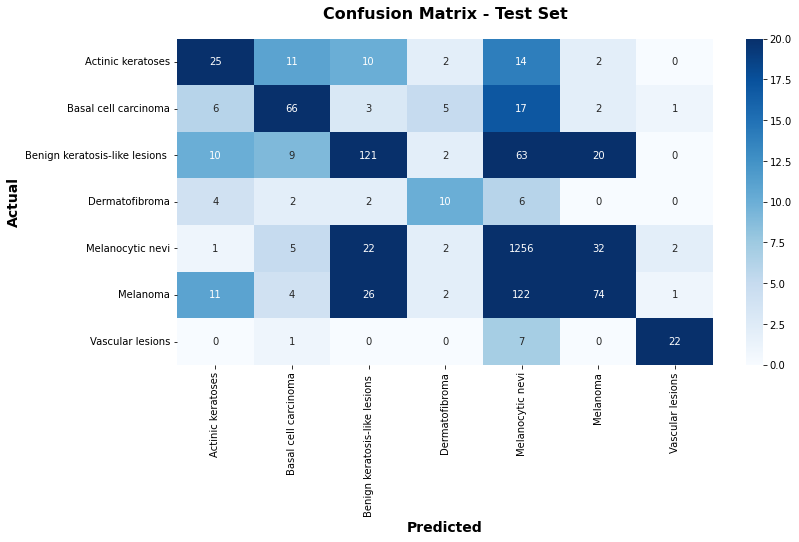

In [13]:


predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
categories = ['Actinic keratoses', 'Basal cell carcinoma',
              'Benign keratosis-like lesions ', 
              'Dermatofibroma', 
              'Melanocytic nevi',
              'Melanoma', 
              'Vascular lesions']

CMatrix = pd.DataFrame(confusion_matrix(y_test_o, predictions), columns=categories, index =categories)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 20,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =90);
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')    
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);


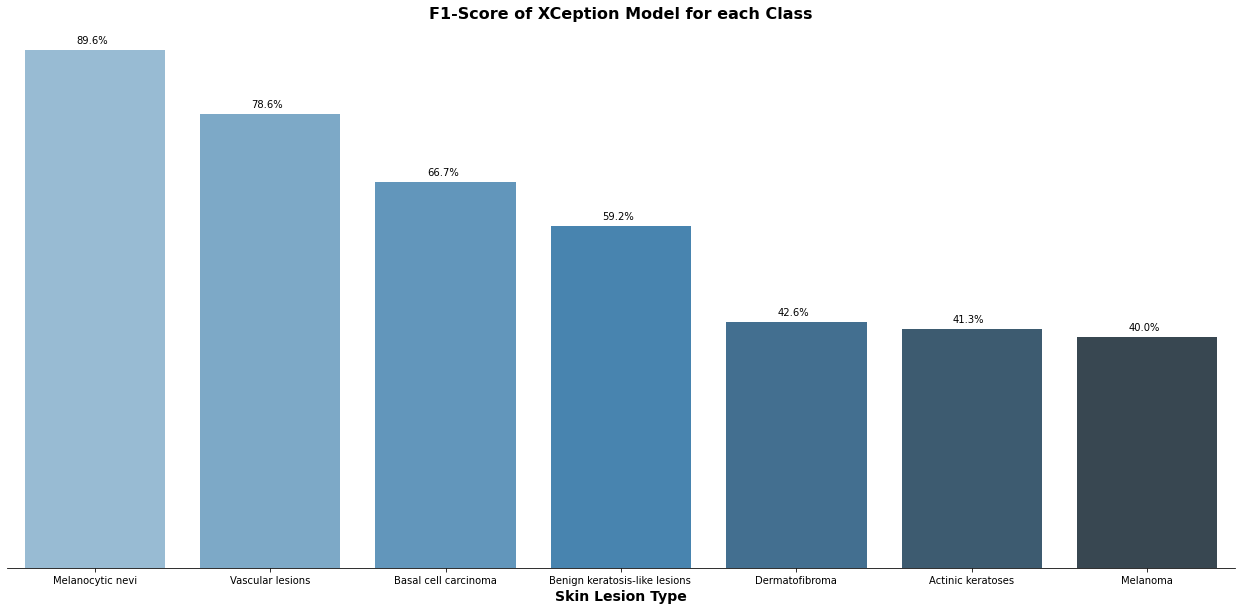

In [14]:
f1 = f1_score(y_test_o, predictions, average=None)
index = categories
f1_df = pd.DataFrame(f1,index, columns = ['F1'])
f1_df.sort_values(['F1'], ascending = False, inplace = True)

plt.figure(figsize=(22,10))
ax = sns.barplot(data =f1_df, x=f1_df.index, y = 'F1',palette = "Blues_d")
#Bar Labels
for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
sns.despine(top=True, right=True, left=True, bottom=False)
ax.set_xlabel('Skin Lesion Type',fontsize = 14,weight = 'bold')
ax.set_ylabel('F1-Score',fontsize = 14,weight = 'bold')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False) 
plt.title("F1-Score of XCeption Model for each Class", fontsize = 16,weight = 'bold');

In [19]:
from sklearn.metrics import classification_report


report = classification_report(y_test_o, predictions, target_names=categories )

print(report)

                                precision    recall  f1-score   support

             Actinic keratoses       0.44      0.39      0.41        64
          Basal cell carcinoma       0.67      0.66      0.67       100
Benign keratosis-like lesions        0.66      0.54      0.59       225
                Dermatofibroma       0.43      0.42      0.43        24
              Melanocytic nevi       0.85      0.95      0.90      1320
                      Melanoma       0.57      0.31      0.40       240
              Vascular lesions       0.85      0.73      0.79        30

                      accuracy                           0.79      2003
                     macro avg       0.64      0.57      0.60      2003
                  weighted avg       0.76      0.79      0.77      2003

